# 🔊 UrbanSound8K Classification (USC)

Welcome!

This notebook is for a school project at [Supinfo](https://www.supinfo.com/) Master grade in 2023 promotion, it covers the classification of sound from the [UrbanSound8K datasets](https://urbansounddataset.weebly.com/urbansound8k.html). 

Dans ce notebook, nous utiliserons des données comprenant des fichiers de sons au format [WAV](https://en.wikipedia.org/wiki/WAV) et leurs métadata correspondant dans un tableau csv. Dans ce projet nous aurons pour objectifs d'appréhender des notions théoriques relatives aux traitements de sons, et ainsi implémenter un modèle de classification.

En premier, nous allons charger et explorer l'ensemble données et méta-données de la dataset UrbanSound8K.
__#TODO__

En fin __#TODO__





## Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa as lisa
import librosa.display

from tqdm.notebook import tqdm, trange

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential

## 1. Exploration des données

In [2]:
df = pd.read_csv("/kaggle/input/urbansound8k/UrbanSound8K.csv")
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [3]:
df.shape

(8732, 8)

*This file includes*

* slice_file_name: 
The name of the audio file. The name takes the following format: [fsID]-[classID]-[occurrenceID]-[sliceID].wav, where:
[fsID] = the Freesound ID of the recording from which this excerpt (slice) is taken
[classID] = a numeric identifier of the sound class (see description of classID below for further details)
[occurrenceID] = a numeric identifier to distinguish different occurrences of the sound within the original recording
[sliceID] = a numeric identifier to distinguish different slices taken from the same occurrence

* fsID:
The Freesound ID of the recording from which this excerpt (slice) is taken

* start
The start time of the slice in the original Freesound recording

* end:
The end time of slice in the original Freesound recording

* salience:
A (subjective) salience rating of the sound. 1 = foreground, 2 = background.

* fold:
The fold number (1-10) to which this file has been allocated.

* classID:
A numeric identifier of the sound class:
0 = air_conditioner
1 = car_horn
2 = children_playing
3 = dog_bark
4 = drilling
5 = engine_idling
6 = gun_shot
7 = jackhammer
8 = siren
9 = street_music

* class:
The class name: air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, 
siren, street_music.

## 2. Librosa library

Librosa is a package for music and audio analysis. 

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.6759664.svg)](https://doi.org/10.5281/zenodo.6759664)


- librosa.load : charger un fichier autio comme une série temporelle à virgule flottante.
- librasa.display.waveshow : ....

In [4]:
sound1, sampling_rate1 = lisa.load('../input/urbansound8k/fold5/100032-3-0-0.wav')
print("Shape :", sound1.shape)
print("Sampling rate: ", sampling_rate1)

Shape : (7002,)
Sampling rate:  22050


## 3. Format WAV


Le Waveform Audio File Format (WAVE, ou WAV en rapport avec son extension de fichier), est un format conteneur destiné au stockage de l'audio numérique mis au point par Microsoft et IBM. 

<img 
    style="display: block; 
           margin-left: auto;
           margin-right: auto;
           width: 30%;"
    src="https://i.stack.imgur.com/Q9xGC.jpg" 
    alt="Canonical wave file structure">
</img>

### Headers
L'en-tête d'un fichier WAV contient plusieurs blocs. 
- En premier, nous avons le **bloc de déclaration**, qui fournit les information sur le fichier wav, comme son format et la taille du fichier. Ce bloc est hériter du RIFF. 
- Ensuite nous avons le **bloc d'écrivant le format audio**. Ce bloc est particulièrement intéressant car il fournit des information comme la fréquence d'échantillonage (en herzt) , le nombre de canaux (1 mono, 2 stéréo) et d'autres informations [wiki]().
- Enfin le **bloc de données**, ou sont stocké les octets des samples de chaque canal.


## 4. Quelques définitions

- **Frequence** : La fréquence est une caractéristique du son qui indique le nombre de vibrations par seconde exprimé en Hertz (Hz). $f= \frac{1}{T}$ $f$ : frequence (Hz) et $T$ : temps pour effectuer un cycle (s).
- **Amplitude** : La magnitude des alternances de pression acoustique, mesurée à partir de 0, est appelée amplitude.
- **Nombre de canaux** : Represente le canal utilisé. 1 pour Mono et 2 pour Stéréo.
- **Frequence d'echantillonage** : La fréquence d'échantillonnage utilisée en audio est le nombre d'échantillons pris par seconde pour enregistrer une piste audio. Il indique combien de fois par seconde l'audio est échantillonné lors de sa conversion de l'analogique au numérique.


## 5. Amplitude

En premier lieu, visualisons l'amplitude d'un echantillons de chacune des class et essayons d'en tirer une conclusion.

In [5]:
def format_filename(folder, filename):
    file_location = '../input/urbansound8k/fold{}/{}'.format(folder,filename)
    return file_location
    
def get_audio_file_by_classId(data,classId) :
    sample_data = data[data['classID'] == classId]
    sample_data = sample_data.reset_index()
    file_locations = []
    for index, row in sample_data.iterrows():
        file_location = format_filename(row['fold'], row['slice_file_name'])
        file_locations.append(file_location)
    return file_locations

def get_sample_by_classId(data, sample, classId):
    groups = data.groupby("classID").sample(sample)
    return get_audio_file_by_classId(groups,classId)

class_name = ( 
    "air_conditioner",
    "car_horn",
    "children_playing",
    "dog_bark", 
    "drilling",
    "engine_idling",
    "gun_shot",
    "jackhammer",
    "siren",
    "street_music"
)

def plot_amplitude(classId, sample):
    files = get_sample_by_classId(df,sample,classId)
    fig, ax = plt.subplots(nrows=sample,sharex='all', figsize=(20,10))
    for idx, file in enumerate(files) :
        s, sr = lisa.load(file)
        ax[idx].set_ylim(ymin=0)
        lisa.display.waveshow(s, sr=22050,ax=ax[idx])
    fig.text(0.06, 0.5, 'Amplitude', ha='center', va='center', rotation='vertical')
    plt.suptitle(f"ClassID : {class_name[classId]}", fontsize=14)
    plt.show()

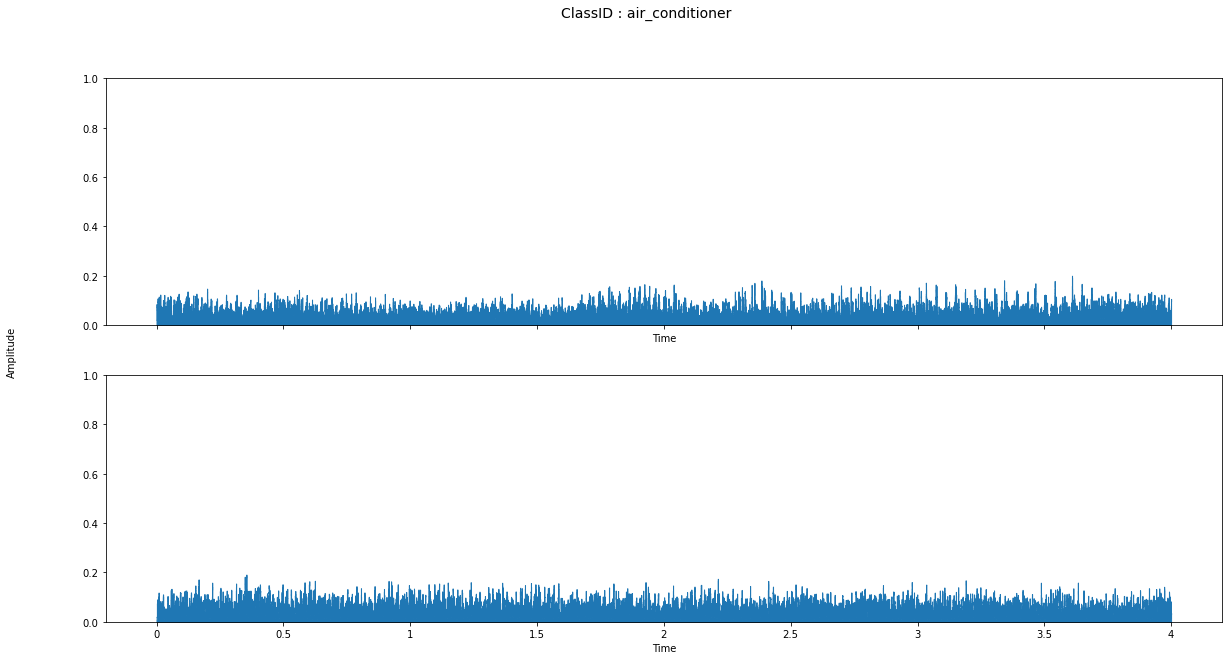

In [6]:
plot_amplitude(0,2)

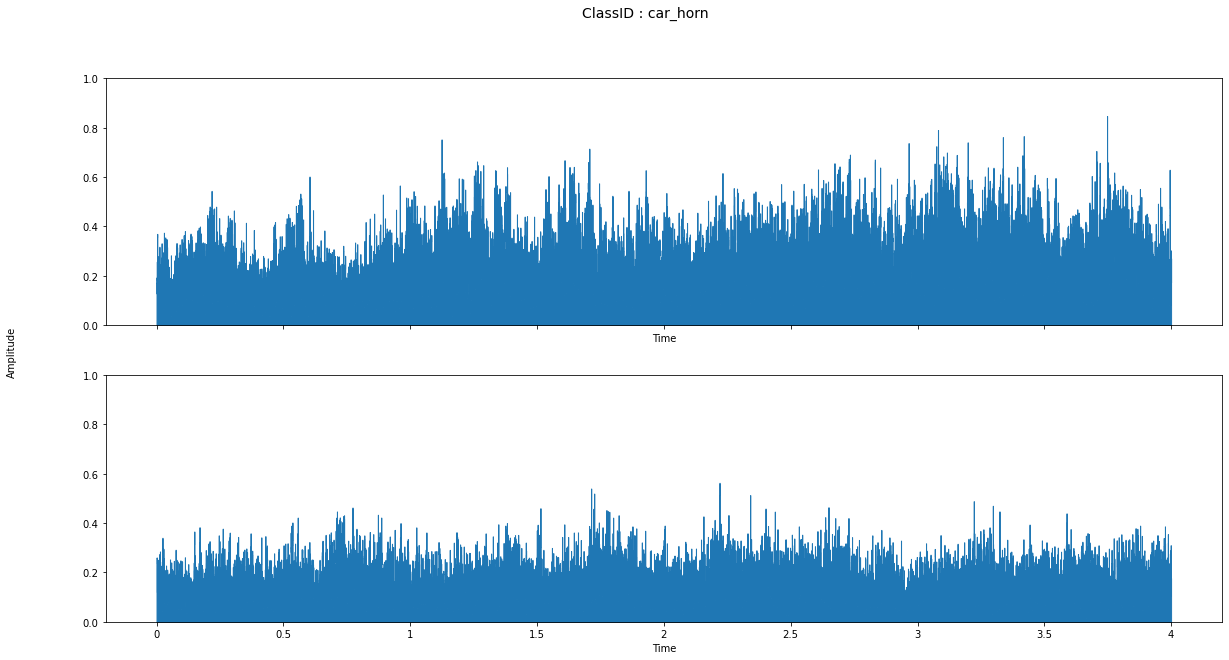

In [7]:
plot_amplitude(1,2)

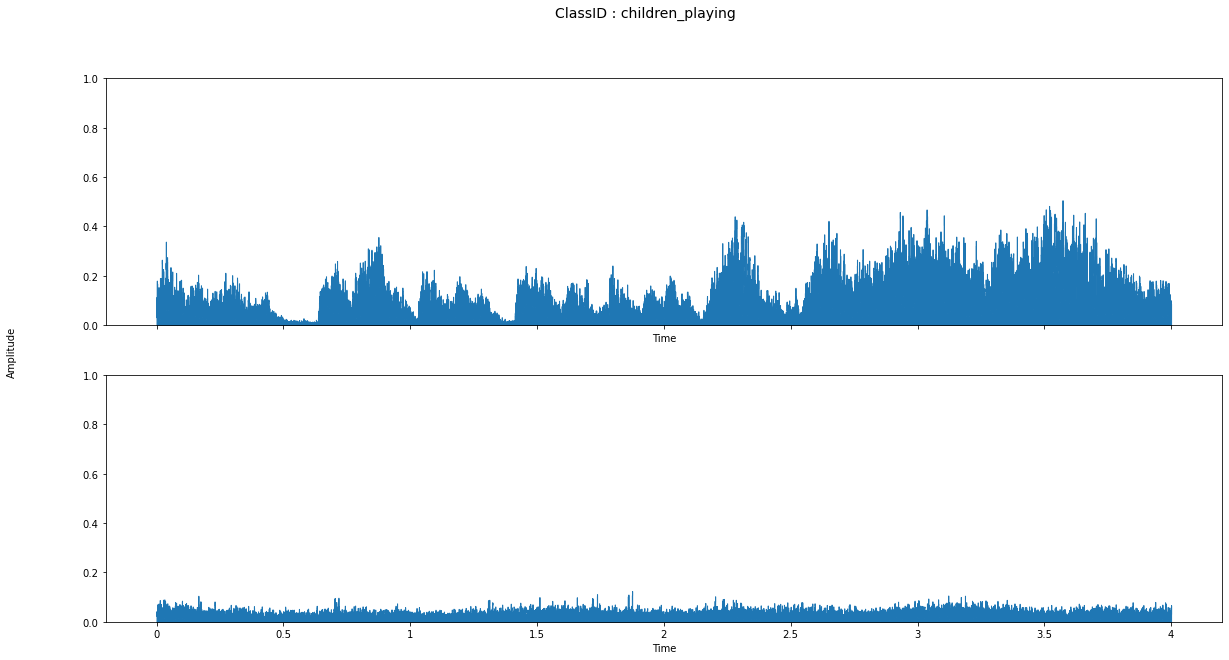

In [8]:
plot_amplitude(2,2)

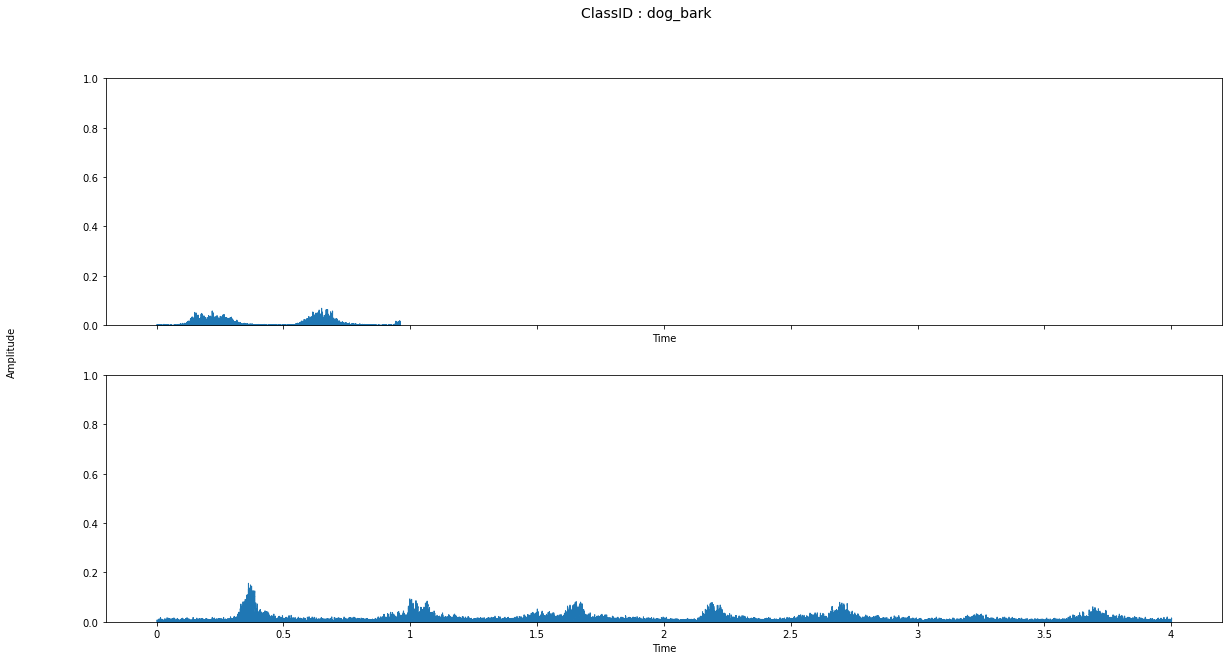

In [9]:
plot_amplitude(3,2)

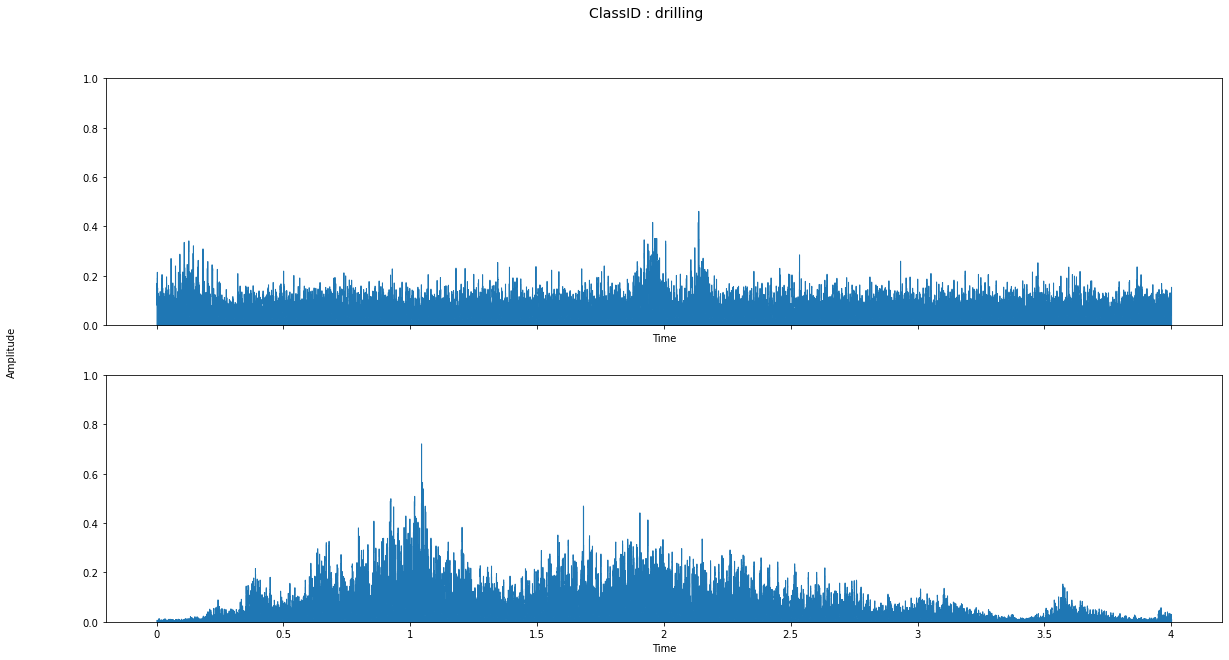

In [10]:
plot_amplitude(4,2)

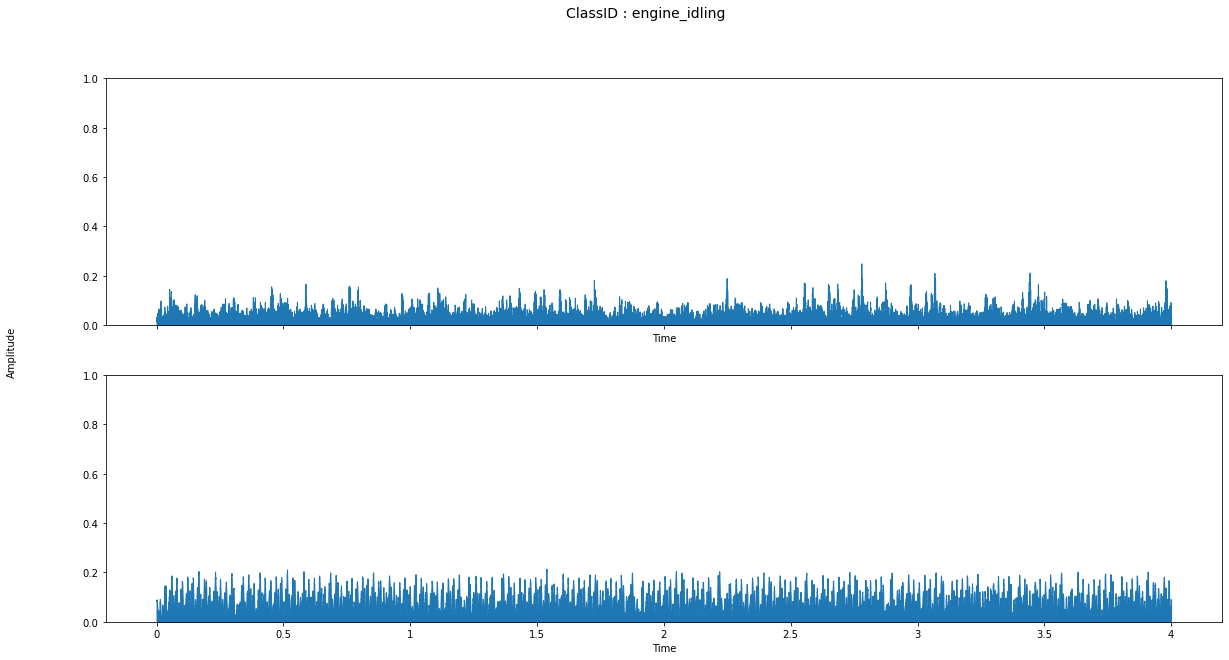

In [11]:
plot_amplitude(5,2)

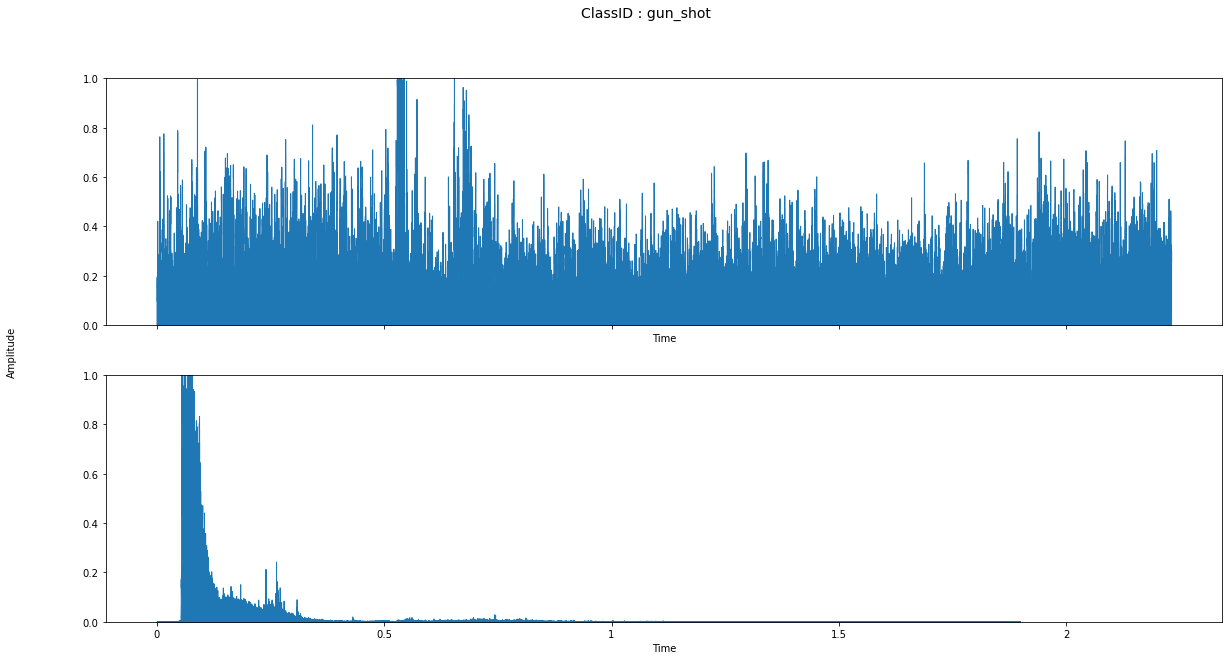

In [12]:
plot_amplitude(6,2)

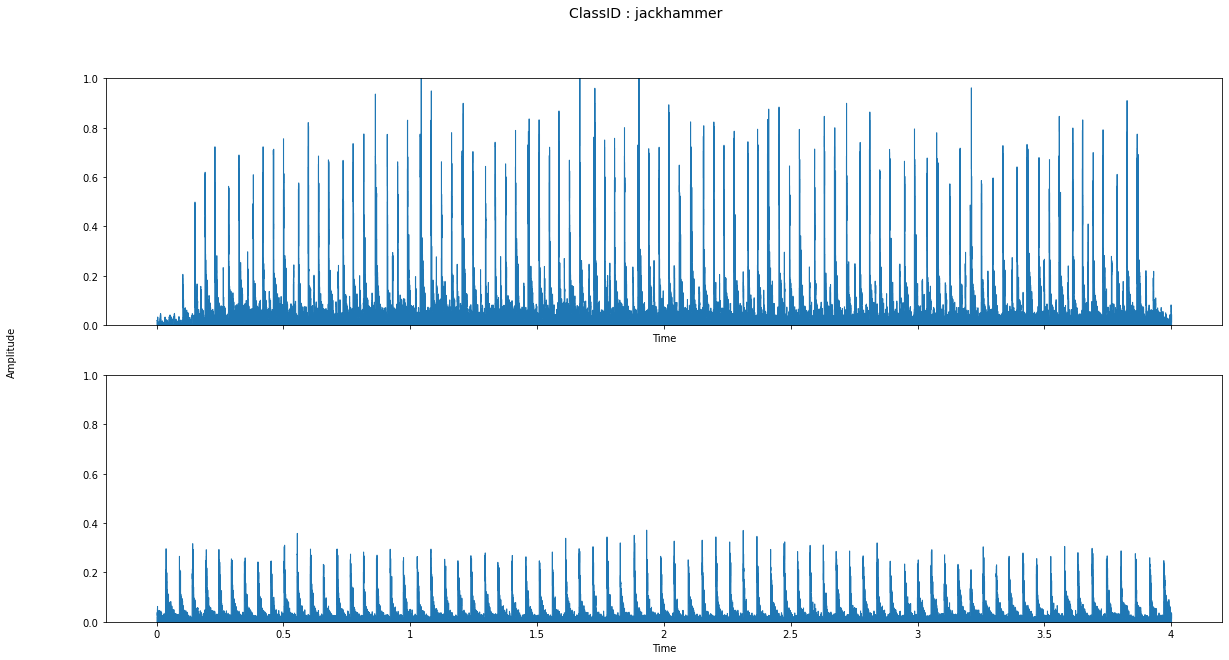

In [13]:
plot_amplitude(7,2)

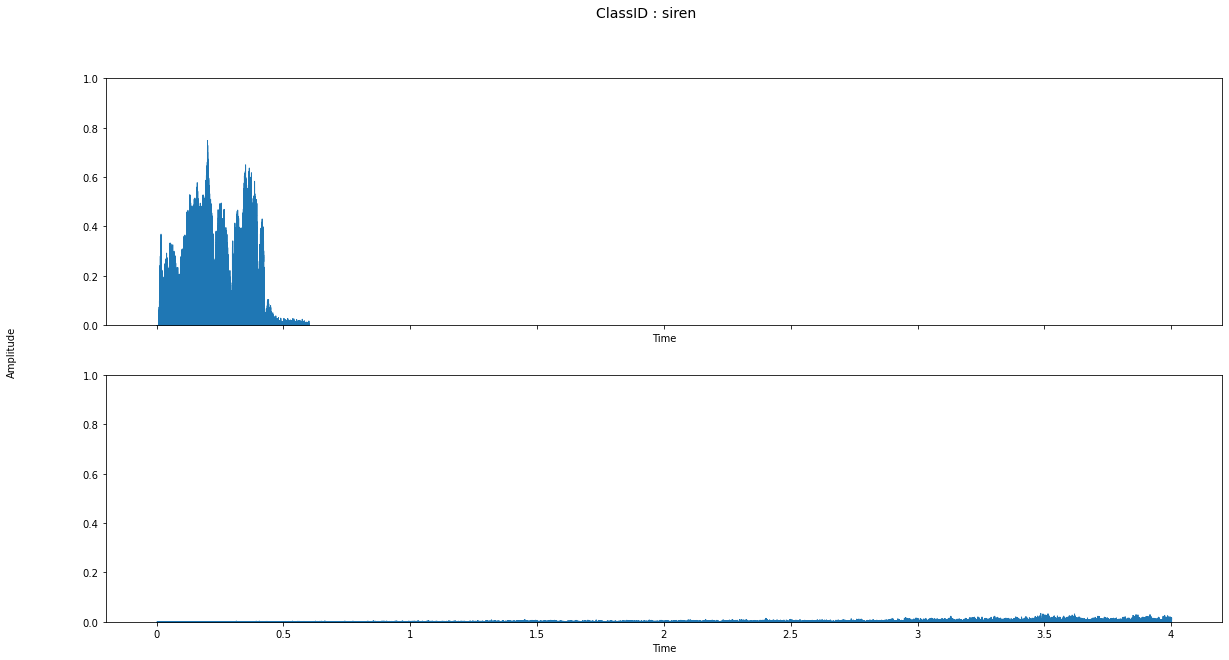

In [14]:
plot_amplitude(8,2)

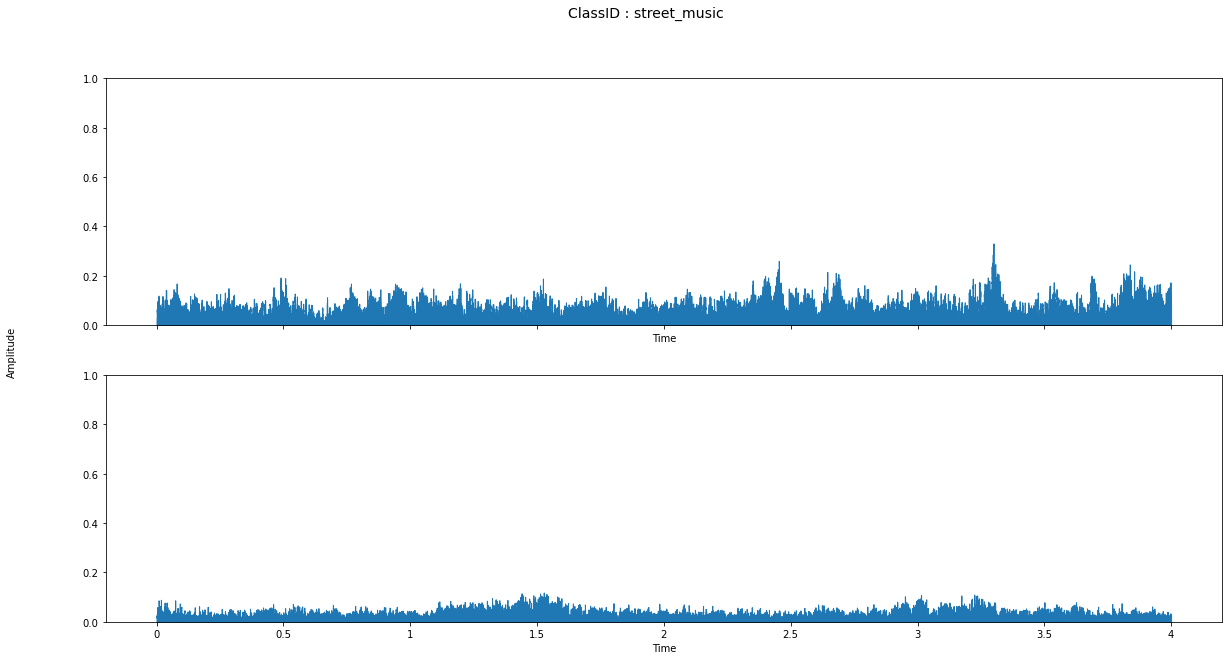

In [15]:
plot_amplitude(9,2)

**NOTES**

* Nous remarquons que les niveaux d'amplitude peuvent varier entre les échantillons d'une même classe.
* Ils peuvent également être similaires entre des classes différentes.
* L'amplitude sonore n'est pas une feature exploitable pour la classification car elle ne contient pas d'informations spécifiques permettant de différencier les différentes classes.


## 6. Dataset est-il équilibré ?



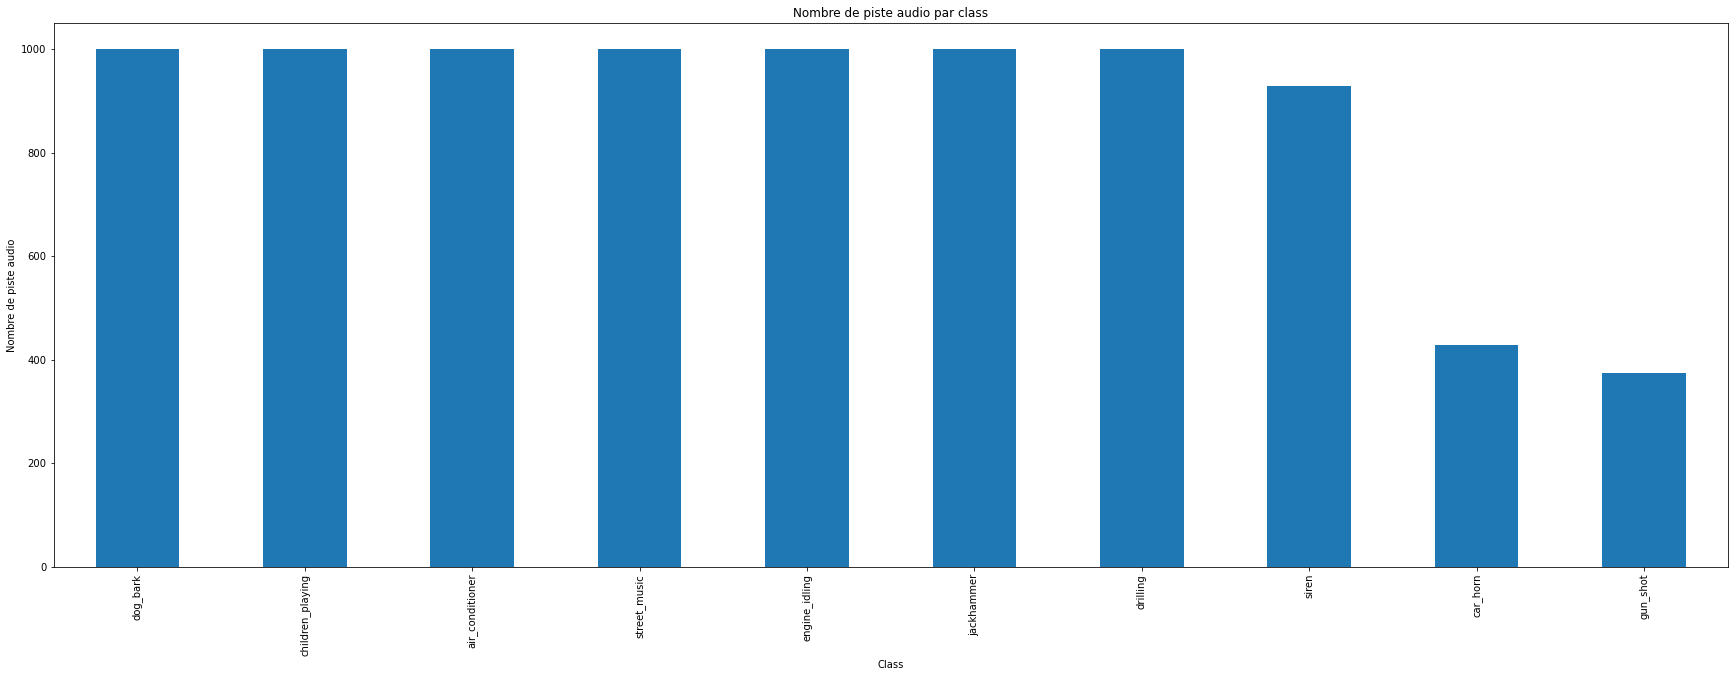

In [16]:
class_group = df['class'].value_counts()

plot = class_group.plot(
    kind='bar', 
    title="Nombre de piste audio par class", 
    figsize=(30,10)
)
plot.set_xlabel("Class")
plot.set_ylabel("Nombre de piste audio");

**NOTES**

* Nous remarquons que le nombre de pistes audio pour `car_horn` et `gun_shut` est inférieur à la moyenne.
* ... (Quelles métrics à utiliser pour évaluer la précision du modèle ?)
* ... (Comment y remedier ?) 
* ... (Ajuster la fonction coût ?)
* ... (Généraiton d'échantillon pour les classes minoritaires ?)

## 7. Distribution du nombre de canaux de chaque son

In [17]:
def get_more_infos_files(data):
    sounds = []
    for i in range(9):
        sounds_by_classID = data[data['classID'] == i]
        for index, row in sounds_by_classID.iterrows():
            s, sr = lisa.load('../input/urbansound8k/fold' + str(row['fold']) + '/' + row['slice_file_name'], sr=None, mono=False)
            sounds.append([row['slice_file_name'], row['fold'], row['classID'],'stereo' if s.shape[0] == 2 else 'mono', s.shape[0] if s.shape[0] == 2 else 1, s.shape[1] if s.shape[0] == 2 else s.shape[0], sr])
    return sounds

In [18]:
files_extend = get_more_infos_files(df)

In [19]:
df_files =  pd.DataFrame(np.array(files_extend,dtype=object), columns=['file_name', 'fold', 'classID', 'channel_type', 'n_channels', 'audio_time_series', 'sample_rate'])
df_files.head()

,file_name,fold,classID,channel_type,n_channels,audio_time_series,sample_rate
0,100852-0-0-0.wav,5,0,stereo,2,176400,44100
1,100852-0-0-1.wav,5,0,stereo,2,176400,44100
2,100852-0-0-10.wav,5,0,stereo,2,176400,44100
3,100852-0-0-11.wav,5,0,stereo,2,176400,44100
4,100852-0-0-12.wav,5,0,stereo,2,176400,44100


In [20]:
df_files[['n_channels','channel_type']].value_counts()

n_channels  channel_type
2           stereo          7048
1           mono             684
dtype: int64

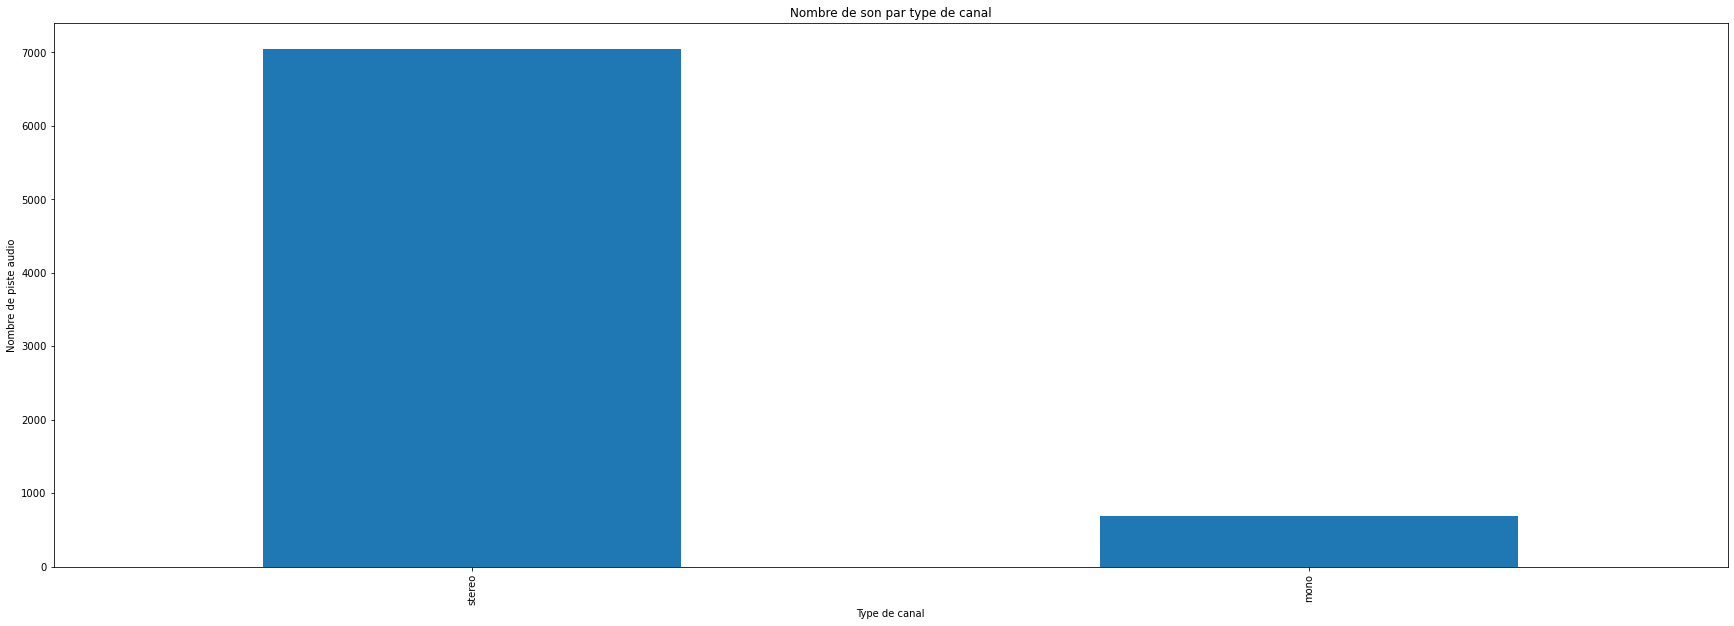

In [21]:
class_group = df_files['channel_type'].value_counts()

plot = class_group.plot(    
    kind='bar',     
    title="Nombre de son par type de canal",     
    figsize=(30,10))
plot.set_xlabel("Type de canal")
plot.set_ylabel("Nombre de piste audio");

**NOTES**

* La distributions du nombre de canaux est déséquilibré, avec une tendance supérieur pour le canal stéréo.
* ... ( Problèmes probables ? ) (Manque de précision lors de la classification)
* ... ( Solution probables ?  ) (Normalisation ?)

## 8. Distribution de la fréquence d'échantillonnage de chaque son

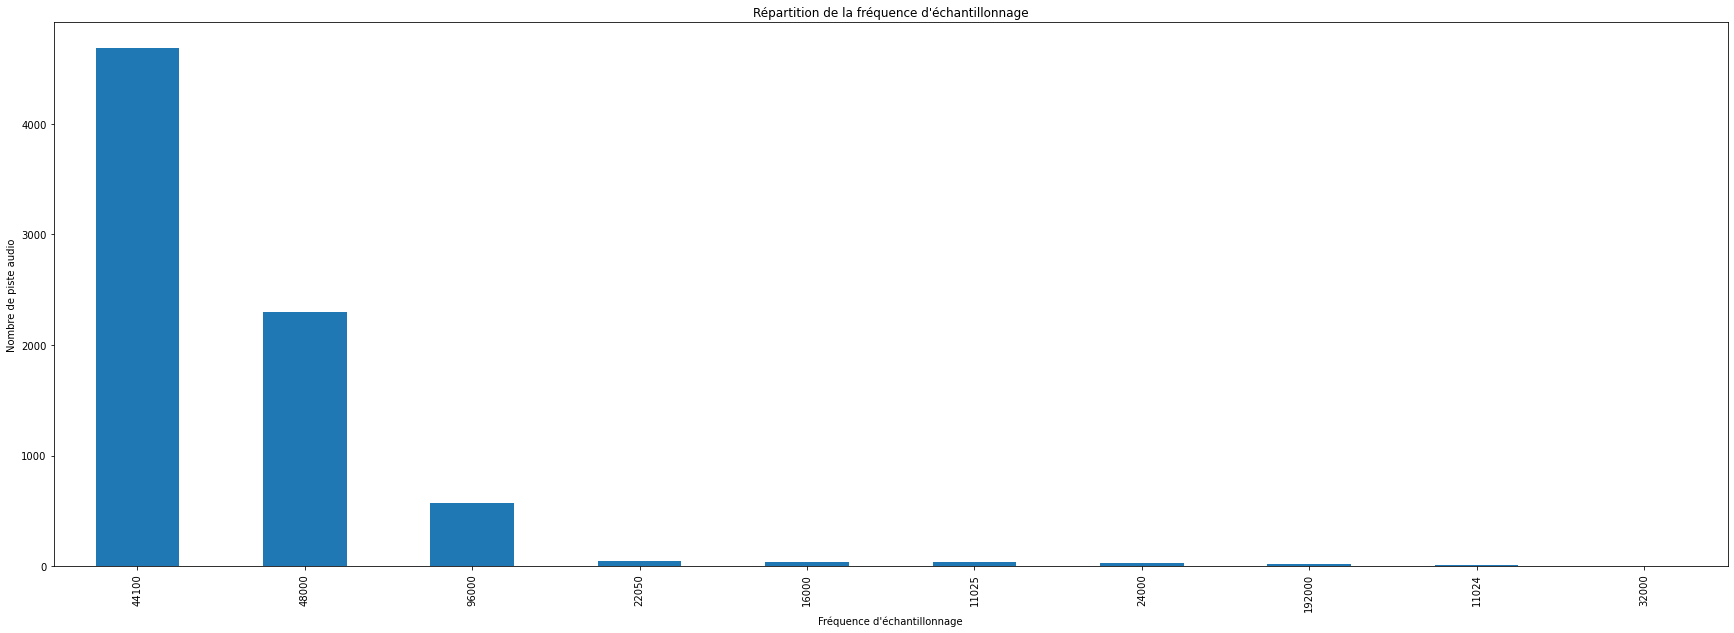

In [22]:
class_group = df_files['sample_rate'].value_counts()

plot = class_group.plot(    
    kind='bar',     
    title="Répartition de la fréquence d'échantillonnage",     
    figsize=(30,10))
plot.set_xlabel("Fréquence d'échantillonnage")
plot.set_ylabel("Nombre de piste audio");

**NOTES**
* La répartition de la fréquence d'échantillonnage est majoritaire pour la fréquence `44100` suivi de `40000`.
* Possible solution de normalisation 
    * Z-score(Standard scaler)
    * Normalisation avec la méthod **librosa.util.normalize** (A confirmer Simon)

In [23]:
# NOTES : Ceci est un test de normalisation à confirmer (SIMON)
data_sample_rate = df_files['sample_rate'].astype(float).values
data_sample_rate = data_sample_rate[np.isfinite(data_sample_rate)]
data_sample_rate_normalized = librosa.util.normalize(data_sample_rate)


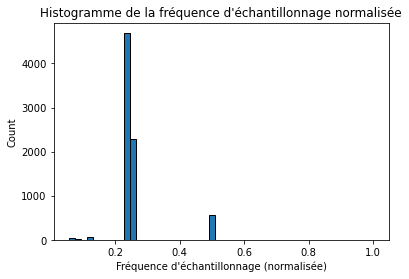

In [24]:
plt.hist(data_sample_rate_normalized, bins=50, edgecolor='k')
plt.xlabel("Fréquence d'échantillonnage (normalisée)")
plt.ylabel('Count')
plt.title("Histogramme de la fréquence d'échantillonnage normalisée")
plt.show()

## 9. Normalisation des variables étudiées par la librarie Librosa

Comme vu précédemment, les sons utilisés sont soit de type mono soit de type stéréo.

La librairie librosa nous permet de convertir les sons en mono.

La fonction utilisée est to_mono() qui fait la de la moyenne des échantillons entre les canaux.

Pour se faire nous passerons le paramètre mono de la fonction librosa.load à True.

Pour normaliser la fréquence d'échantillonnage de chaque son (Ou sample rate), nous allons utiliser le paramètre sr de la fonction load.

Cela nous permettra de définir le taux d'échantillonnage pour tous les sons.

## 10. “Mel-spectogram“ et “Mel-frequency cepstral coefficients“

Le **Mel-spectrogram** est un type de représentation visuelle des données audio qui utilise le système auditif humain comme référence. Il se base sur la théorie que les fréquences audibles par l'oreille humaine ne sont pas perçues de manière uniforme mais sont plutôt regroupées en mélodies distinctes. Cette échelle de fréquences utilisée s'appelle l'échelle **Mel**, elle est basée sur la perception humaine de la fréquence et non sur une échelle linéaire en Hertz. Le signal audio est analysé en fréquences et chaque bande de fréquences est convertie en une intensité en dB, qui est ensuite représentée en couleur pour créer une image (HeatMap).

Il utilise une échelle de fréquences appelée échelle Mel, qui est basée sur la perception humaine de la fréquence et non sur une échelle linéaire en Hertz. Le signal audio est analysé en fréquences et chaque bande de fréquences est convertie en une intensité en dB, qui est ensuite représentée en couleur pour créer une image.

![image.png](https://miro.medium.com/max/1400/1*zX-rizZKXXg7Ju-entot9g.png)

**L'échelle Mel** est dérivée de l'étude de la psychologie de l'audition et de la perception de la fréquence. Elle a été développée pour refléter la façon dont l'oreille humaine perçoit les fréquences différemment selon leur valeur.
Elle est calculée de la manière suivante :

\begin{equation*}Mel(f)=295 log_{10} (1+\frac{f}{700})\end{equation*}

où $Mel(f)$ est l'échelle logarithmique de l'échelle de fréquence normale f. L'échelle Mel a un intervalle mel-fréquence constant, et couvre la gamme de fréquences de 0 Hz - 20050 Hz.

Ainsi les réseaux de neurones formés sur des Mel-spectrogrammes peuvent alors mieux comprendre les caractéristiques sonores qui sont importantes pour les tâches telles que la reconnaissance de la parole et la reconnaissance de la musique.


### Mel-frequency cepstral coefficients (MFCCs)

Afin de comprendre ce que sont les **Mel-frequency cepstral coefficients**, il nous faut commencer par savoir ce que sont les **fréquences cepstrales** ainsi que la **Transformée de Fourier**.

Les **fréquences cepstrales** sont des représentations du signal audio qui capture les caractéristiques spectrales du signal audio en utilisant une transformation mathématique, comme la **Transformée de Fourier**.

La **Transformée de Fourier** est une technique mathéamtique pour étudier les propriétés spectrales des signaux audios et vidéos, mais également dans d'autre domaines. Elle permet de détecter les fréquences présentes dans un signal et des les isoler pour les étudier. La **Transformée de Fourier** connait deux types : La **Transformée de Fourier discrète (DFT)** et la **Transformée de Fourier continue (FT)**. La **DFT** est utilisée pour analyser des échantillons numériques, tandis que la **FT** est utilisée pour des signaux continus.

Dans notre contexte, la **DFT** sera le type utilisé. Sa définition pour un signal $s$ de $N$ échantillons est la suivante :

\begin{equation*}S(k)=\sum_{n=0}^{N-1} s(n)e^{-2\pi k \frac{n}{N}}\end{equation*}

Pour $0\le k<N$ Ainsi les **coefficients cepstraux de fréquence Mel** sont un type de représentation de la caractéristique du signal audio. Ils sont basés sur la transformation de **fréquences cepstrales** qui calcule les **coefficients cepstraux** à partir d'une décomposition en fréquence du signal comme expliqué plus-tôt. Cette fréquence est ensuite appliquée sur l'échelle de fréquence **Mel**. Cette représentation permet de capturer les caractéristiques spectrales du signal audio, telles que les **formants**, qui sont important dans la reconnaissances de la parole et l'analyse audio.
Ces coefficients sont utilisés pour nourrir divers algorithmes permettant la classification audio par exemple.

## 11. Construire un dataframe panda qui contiendra les MFCCs et les labels de chaque son.

### Exemple d'extraction MFCC

**Method**

Nous utiliserons des procédures de la librairie librosa.

1. Parcourir toutes les pistes audio en  normalisant :
   * *Le nombre de canaux* :`to_mono(...)` Mono. (Essayer d'autres canaux comme stéréo lors de l'apprentissage)
   * *Les fréquence d'échantillonnage* :`resample(...)` Methode de Fourier car le signal est périodique voir [scipy.signal.resample](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html#scipy.signal.resample), (Essayer plusieurs valeurs lors de l'apprentissage)
2. Extraction de la feature MFCCs :
    * *Param1* : le nombre de filtre de mels `n_mels`. (Essayer plusieurs valeurs lors de l'apprentissage) (entre 10 - 40) (Mésurer performance)
    * *Param2* : le mode de padding `pad_mode`. (Essayer plusieurs valeurs lors de l'apprentissage)
    * Paramn : ...
3. Ensuite On encodera les label en valeurs categorical (Cette étape pourra être fait sur en crean les transformer ? à voire)
4. Ensuite on rajoutera les valeurs MFCCs obtenues au dataframe qui seront nettoyer et reshape .

In [25]:
RATE = 44100                             # Définir la fréquence d'échantillonnage cible
N_MFCC = 12                              # Nombres de filtre de mels

files = get_sample_by_classId(df,1,6)    # Random fichier par class
y, sr = lisa.load(files[0],sr=None, mono=False)              # Chargment du fichier

print(f"Fichier ==> {files[0]}")

Fichier ==> ../input/urbansound8k/fold1/197318-6-5-0.wav


In [26]:
# Normalisation des canaux ou mono = True dans le load
y_mono = lisa.to_mono(y)

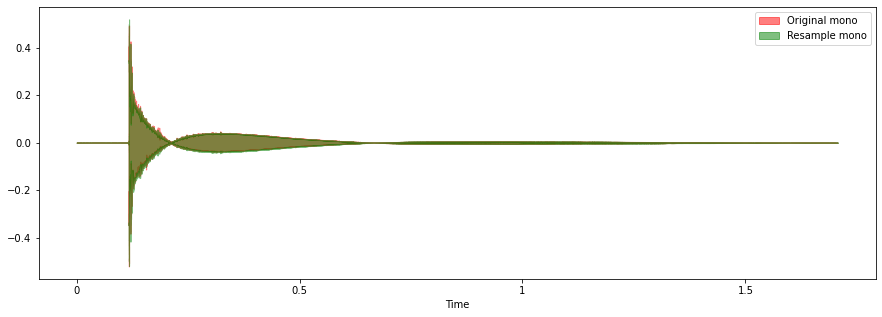

In [27]:
# Normalization sample rate 
y_rsmple = lisa.core.resample(y=y_mono,orig_sr=sr,target_sr=RATE, scale=True)

plt.figure(figsize=(15,5))
lisa.display.waveshow(y, sr=sr, color='r', label="Original mono", alpha=0.5 )
lisa.display.waveshow(y_rsmple, sr=RATE, color='g', label="Resample mono", alpha=0.5)
plt.legend()
plt.show()

[Text(0.5, 1.0, 'MFCCs')]

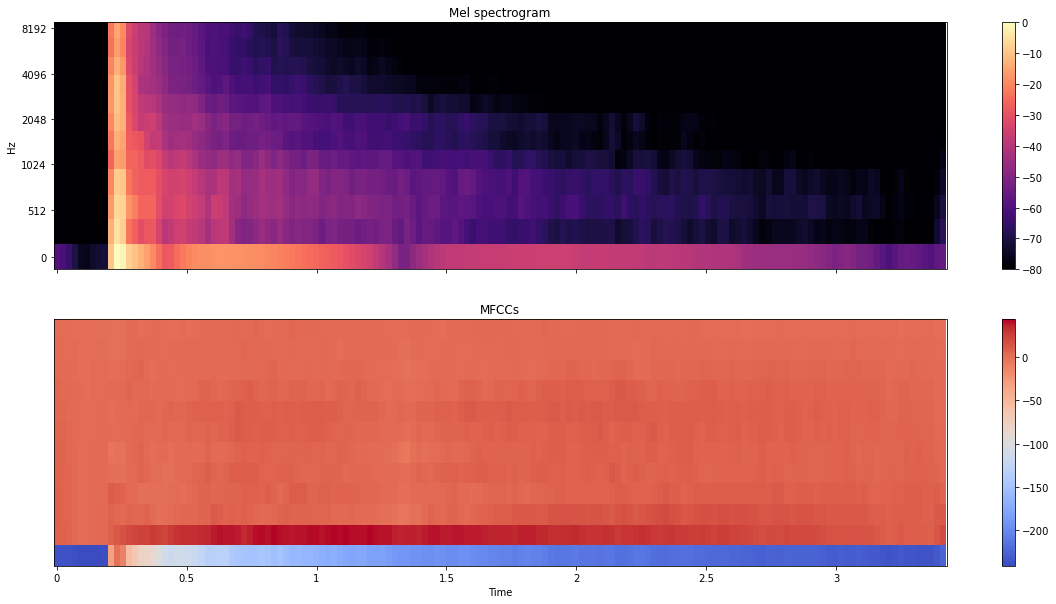

In [28]:
# Extraction de la feature LM
S = lisa.feature.melspectrogram(y=y_rsmple, sr=RATE, n_mels=N_MFCC, fmax=8000,center=True, pad_mode="linear_ramp")

# Extraction de la feature MFCC
mfccs = lisa.feature.mfcc(S=lisa.power_to_db(S))
#mfccs = lisa.feature.mfcc(y=y_rsmple, sr=RATE, n_mfcc=N_MFCC)

# Plot https://librosa.org/doc/main/generated/librosa.feature.mfcc.html
fig, ax = plt.subplots(nrows=2, sharex=True,figsize=(20,10))

img = lisa.display.specshow(lisa.power_to_db(S, ref=np.max), 
                            x_axis='time', y_axis='mel', fmax=8000, ax=ax[0])

fig.colorbar(img, ax=[ax[0]])
ax[0].set(title='Mel spectrogram')
ax[0].label_outer()
img = lisa.display.specshow(mfccs, x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='MFCCs')

In [29]:
np.array(mfccs[4])

array([ 7.2851987 ,  6.6537156 ,  5.454204  ,  3.6015553 ,  1.5990177 ,
        1.3431641 ,  2.2369847 ,  2.707411  ,  2.9715781 ,  0.32882017,
       -0.36480474, -0.48526478,  2.8716402 ,  3.8543897 ,  5.6901493 ,
        4.256586  ,  1.527307  ,  1.777159  , -0.57067096,  0.7671907 ,
        1.2268026 ,  1.9469719 ,  3.739489  ,  5.7263384 ,  6.988677  ,
        8.760805  ,  5.861351  ,  5.147643  ,  6.2055354 ,  8.630743  ,
        8.79717   , 10.297117  ,  9.759739  ,  9.46164   ,  6.8478527 ,
        5.8523035 ,  7.3394766 ,  7.965652  ,  8.234979  ,  7.9109955 ,
        6.166607  ,  5.147256  ,  5.1033955 ,  4.8950267 ,  6.156378  ,
        6.4441376 ,  6.34159   ,  5.5722537 ,  3.5537033 ,  4.917326  ,
        4.1812143 ,  4.922819  ,  4.217295  ,  3.1457665 ,  2.237656  ,
        2.291359  ,  2.2385592 ,  0.7895306 ,  1.4480519 ,  3.5446382 ,
        5.9729433 ,  4.9505577 ,  3.9926996 ,  5.710004  ,  7.64569   ,
        8.129435  ,  7.916068  ,  7.1039634 ,  7.671079  ,  8.19

### Fonction d'extraction

In [30]:
def load_wave(folder, file_name) :
    '''
    Chargement du fichier wave sans mono et sample rate
    qui seront normalisé plutard.
    
    :param folder: folder index
    :param file_name: file name
    :return: numpy array wave sound 
    '''
    path = '../input/urbansound8k/fold' + folder + '/' + file_name
    
    # Load sans le sr et mono a false (plus rapide )
    s, sr = lisa.load(path, sr=None, mono=False)
    
    return s, sr

In [31]:
def extract_mfcc_features(wav,sr,sr_target=RATE, n_mfcc=N_MFCC, mono=True, padding='linear_ramp'):
    '''
    Extraire la feature mfcc pour tout le data frame,
    Appliquera les normalisations de sample rate et mono
    
    :param wav: fichier wav chargé
    :param sr: sample rate,
    :param n_mfcc: nombre de filtre de mels
    :param mono: mono normalisation
    :param padding: padding mode
    :return: 2d numpy array MFCC
    '''
    y = wav
    # Normalisation des canaux à mono
    if mono : y = lisa.to_mono(y)
        
    # Normalization sample rate 
    y = lisa.core.resample(y=y,orig_sr=sr ,target_sr=sr_target, scale=True)
    
    # Extraction de la feature LM
    S = lisa.feature.melspectrogram(y=y, sr=sr_target, n_mels=n_mfcc,center=True, pad_mode=padding)
    
    # Extraction de la feature MFCC 
    mfccs = lisa.feature.mfcc(S=lisa.power_to_db(S))
    
    # Moyenne pour reduire la dimension (12,) au lieu de (12,163)
    mfcc_mean = mfccs.mean(axis=1)
    
    return mfccs

In [32]:
def row_parser(row,sr_target=RATE, n_mfcc=N_MFCC, mono=True, padding='linear_ramp'):
    '''
    Parser chaque ligne en extrayant la feature mfcc du son
    et le label
    :exemple: l, f = row_parser(df.iloc[1])
    :return: label, mfcc feature(2d numpy array)
    '''
    folder = str(row['fold']);
    file_name = row['slice_file_name']
    label = row['classID']
    
    wave,sr = load_wave(folder, file_name)
    
    mfccs = extract_mfcc_features(wave,sr, sr_target, n_mfcc, mono, padding)
    
    return label, mfccs

In [33]:
def build_feature_df(df, n_mfcc=N_MFCC, mono=True, padding='linear_ramp'):
    '''
    Construire le dataframe avec les feature extraites.
    :param df: dataframe de base
    :param sr: sample rate,
    :param n_mfcc: nombre de filtre de mels
    :param mono: mono normalisation
    :param padding: padding mode
    
    Return
    -----
    
    df_new: mfcc et label sans normalisation
    df_new_mean : mfcc et label avec normalisation
    '''
    
    y =  []
    headers = ''
    mfcc_cols = ["mfcc" + str(i) for i in range(N_MFCC)]
    
    df_new = pd.DataFrame(columns=mfcc_cols)
    df_new_mean = pd.DataFrame(columns=mfcc_cols)
    
    # Extraction des mfccs
    for index in trange(len(df)):
        # extaction des mfcc et label
        l , mfccs = row_parser(df.iloc[index])
        
        # METHOD1 : Prendre les features sans normalisation (peut être utilis pour la convolution)
        mfccs_feat = [np.array(mfccs[i]) for i in range(N_MFCC)]
        mfcc_df = pd.DataFrame([mfccs_feat],columns=mfcc_cols)
        df_new = pd.concat([df_new, mfcc_df], ignore_index=True)

        # METHOD2 : Prendre la moyenne pour chaque feature        
        mfcc_df_mean = pd.DataFrame([mfccs.mean(axis=1)],columns=mfcc_cols)       
        df_new_mean = pd.concat([df_new_mean, mfcc_df_mean], ignore_index=True)
        
        y.append(l)
    
       
    df_new['target'] = y
    df_new_mean['target'] = y
    
    return df_new , df_new_mean

In [34]:
df_new, df_new_mean = build_feature_df(df)

  0%|          | 0/8732 [00:00<?, ?it/s]

In [35]:
# DF 1 mfcc sans moyenne  (Utilisé pour les models plus complex pour plus de precision, en gros on peut les utilisés comme des images)
df_new.head()

,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,target
0,"[-135.74173, -101.46314, -64.36693, -36.833317...","[55.248177, 61.617123, 61.06035, 54.64424, 51....","[-8.841042, -15.30739, -16.66063, -20.90027, -...","[-9.744066, -9.935813, -13.410486, -15.264498,...","[5.431008, 1.3345685, -10.12221, -13.291161, -...","[-2.353629, -5.521757, -3.8823562, -6.3236537,...","[-3.78961, -8.158735, -18.111383, -21.313635, ...","[1.8449187, -0.46375751, -3.313704, -5.0769286...","[1.5160402, -1.8529212, -7.9156966, -10.24823,...","[0.79525423, -1.4238863, -4.507345, -4.3649178...","[1.4396148, 0.50295067, 2.690568, 2.1983566, 1...","[-1.069807, -0.03985977, 1.4106903, 0.35289574...",3
1,"[-159.05482, -148.23743, -148.23972, -147.2612...","[37.71492, 39.77198, 41.54928, 40.110695, 39.9...","[-8.988451, -9.302223, -7.1726766, -8.61495, -...","[7.394514, 7.1214123, 11.409351, 7.9142838, 6....","[0.34440517, -0.69364846, -1.0668975, -0.79151...","[1.9493496, 2.194893, 3.6654973, 4.353743, 4.0...","[-2.230015, -2.4499552, -2.2119243, -0.6189476...","[4.4840145, 4.2955546, 6.039078, 6.407827, 7.1...","[-0.53499347, 0.13209993, 0.27207586, -1.07946...","[3.603817, 3.9008408, 4.3821197, 3.5594504, 2....","[2.8145967, 1.9297905, 0.31309462, 0.17040968,...","[2.6460018, 3.0548725, 2.4366512, 1.3179855, 0...",2
2,"[-169.7412, -157.579, -156.5665, -159.39815, -...","[52.03341, 53.572735, 55.127937, 50.70957, 50....","[-16.164284, -17.793304, -18.770485, -19.52255...","[15.054264, 14.888354, 16.164423, 15.963282, 1...","[4.716559, 3.8908927, 4.989666, 5.3127093, 5.0...","[5.8931656, 4.1815166, 3.6371732, 5.0669193, 7...","[-4.0404806, -4.507389, -5.22061, -6.4307284, ...","[4.9354887, 3.9914496, 2.971644, 4.3984385, 4....","[0.26455593, -0.4577968, 0.39365268, -0.101214...","[1.4618111, 2.0013494, 1.8667736, 3.4380016, 3...","[-1.3329573, -0.0061006546, -0.13340092, 0.794...","[-0.67669487, -0.35814285, -1.1621933, -0.6485...",2
3,"[-142.6494, -133.64006, -132.28024, -129.57712...","[44.41956, 40.80793, 39.97816, 42.14926, 46.28...","[-20.825573, -19.824337, -19.785831, -21.80397...","[3.8024135, 5.7079453, 8.715632, 7.3277454, 7....","[4.7170815, 5.083879, 5.829896, 3.8744907, 0.5...","[5.1647496, 3.8780913, 2.688295, 2.4353147, 2....","[2.2341924, 0.45430568, -0.85323435, -0.780693...","[8.367319, 7.9741178, 8.1371765, 8.449718, 6.6...","[-2.3645844, -1.65723, -1.7317379, -0.9270643,...","[2.8203826, 2.3409705, 0.97359943, 0.56686854,...","[0.26363564, 0.33237362, -1.17171, -1.8948832,...","[-2.223404, -1.462965, -1.9885216, -1.9468498,...",2
4,"[-159.45323, -149.07332, -147.83176, -148.4387...","[48.03716, 50.210896, 50.694595, 48.63239, 48....","[-21.873756, -20.627695, -20.133472, -22.63242...","[14.295672, 15.589249, 14.83674, 13.148945, 14...","[2.952316, 1.1227977, -0.85530865, 0.14732921,...","[9.194634, 7.265034, 6.6987877, 6.578824, 6.97...","[-0.8796146, -2.5380383, -3.57613, -3.6567936,...","[6.772382, 6.912969, 8.572481, 8.307034, 5.944...","[-1.3416998, -3.0277941, -3.4546437, -2.636023...","[3.9356928, 2.9544792, 4.2856073, 3.6692963, 2...","[1.2883329, 0.25636864, 1.5967398, 2.3121223, ...","[0.64183426, 1.0018005, 1.0452099, 0.38407898,...",2


In [36]:
# DF2 MFCC avec moyenne (Utilisé pour les models simple)
df_new_mean.head()

,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,target
0,-70.623161,45.247414,-24.486874,-15.708547,-10.571578,-0.987208,-10.615149,-2.556847,-3.876858,-1.239909,1.524140,-0.271601,3
1,-140.689102,50.064571,-24.936373,12.147318,0.955449,6.760194,-3.032621,5.624805,-3.177524,2.759266,0.455006,-0.640852,2
2,-152.660446,52.992855,-20.620594,10.175644,-0.580500,5.385178,-1.080464,6.805319,-1.997032,3.025248,1.112118,-0.010080,2
3,-130.209366,41.013565,-13.047976,9.194559,3.116994,4.171854,-2.010906,4.275599,-3.611723,1.677038,-0.574434,-1.039025,2
4,-148.783646,50.920109,-24.050747,11.359112,1.076818,6.556254,-0.908651,6.069875,-2.994016,3.688080,1.210047,-0.576798,2


**NOTES**
- Nous avons extrait les features mfcc.
- Il ya deux methode une avec la moyenne pour chaque mfcc (celle que l'on peut trouver partout sur internet), et l'autre qui ajoute les mfcc tel qu'ils sont.


### Preparation du data frame

## 12. Séparer les données en un jeu d'entraînement/validation et un jeu de test.

In [37]:
target = "target"

# J'utilise avec mean ici
X = df_new_mean.iloc[:,:-1]
y = df_new_mean['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

## 13. Premier réseau de neurones

Vu au jour 4 du cours, à retravailler pour l'adapter au projet

In [38]:
input_dim  = X_train.shape[1] # Nombre de variables en entrée du réseau

print(input_dim)

12


In [39]:
def create_linear_model():
    model = Sequential()    
    model.add(Dense(44, input_dim = input_dim, activation = "relu") )
    model.add(Dense(1, activation = "sigmoid"))
    model.compile(optimizer = "adam",loss = "binary_crossentropy", metrics = ["accuracy"])
    return model

In [40]:
linear_model = create_linear_model()

2023-02-11 20:26:31.164543: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [41]:
linear_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 44)                572       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 45        
Total params: 617
Trainable params: 617
Non-trainable params: 0
_________________________________________________________________


In [42]:
nb_epochs = 10
history = linear_model.fit(x = X_train,y = y_train,
                    epochs = nb_epochs,validation_data = (X_val, y_val),
                    batch_size = 32)

2023-02-11 20:26:32.027484: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
164/164 [==============================] - 1s 3ms/step - loss: -238.9365 - accuracy: 0.0561 - val_loss: -753.2179 - val_accuracy: 0.0446
Epoch 2/10
164/164 [==============================] - 0s 2ms/step - loss: -1846.1504 - accuracy: 0.0485 - val_loss: -3231.6555 - val_accuracy: 0.0446
Epoch 3/10
164/164 [==============================] - 0s 2ms/step - loss: -5264.3018 - accuracy: 0.0485 - val_loss: -7508.6177 - val_accuracy: 0.0446
Epoch 4/10
164/164 [==============================] - 0s 2ms/step - loss: -10476.5977 - accuracy: 0.0485 - val_loss: -13530.8145 - val_accuracy: 0.0446
Epoch 5/10
164/164 [==============================] - 0s 2ms/step - loss: -17407.0488 - accuracy: 0.0485 - val_loss: -21292.8652 - val_accuracy: 0.0446
Epoch 6/10
164/164 [==============================] - 0s 2ms/step - loss: -26062.3652 - accuracy: 0.0485 - val_loss: -30628.1836 - val_accuracy: 0.0446
Epoch 7/10
164/164 [==============================] - 0s 2ms/step - loss: -36396.0078 - accuracy

In [43]:
_, accuracy = linear_model.evaluate(X_test, y_test)
print("Accuracy: {:.2f}%".format(accuracy * 100))

55/55 [==============================] - 0s 1ms/step - loss: -85803.6328 - accuracy: 0.0555
Accuracy: 5.55%


## 14. Entraînement du modèle construit et mesurer sa performance.

## 15. Réseau de neurones convolutif (couches de convolution, couche de "pooling", "dropout", couches cachées complètement connectées)

In [44]:
def create_model_convolution():
    model = Sequential()
    
    # Couches de convolution (extraction de motifs (features extraction))
    model.add(Conv2D(5,
                     kernel_size = (3,3),
                     input_shape = input_shape,
                     padding = 'same',
                     activation = "relu"
                    ))
        
    model.add(MaxPooling2D(pool_size = (3,3)))
    
    model.add(Conv2D(10,
                     kernel_size = (5,5),
                     padding = 'same',
                     activation = "relu"
                    ))
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    # Couche d'applatissement
    model.add(Flatten())
    
    # Couches denses
    model.add(Dense(10, activation = "relu"))
    
    # Couche de sortie
    model.add(Dense(output_dim, activation = "softmax"))
    
    model.compile(optimizer = Adam(learning_rate=0.01),
                  loss = "categorical_crossentropy",
                  metrics = ["accuracy"])
    return model

## 16. Entraînement du modèle construit et mesurer sa performance.

## 17. Test de différentes structures et différentes valeurs des hyperparamètres

## 18. Meilleur modèle

**NOTES** :

* ...
* ...
* ...

## Acknowledgements

* J. Salamon, C. Jacoby and J. P. Bello, **"A Dataset and Taxonomy for Urban Sound Research"**, 22nd ACM International Conference on Multimedia, Orlando USA, Nov. 2014.
* Wikipedia contributors. (2023, January 5). WAV. Wikipedia. https://en.wikipedia.org/wiki/WAV
* Wikipedia contributors. (2023b, January 16). Waveform Audio File Format. https://fr.wikipedia.org/wiki/Waveform_Audio_File_Format
* Hwung, C. (2022, June 4). WAV Files: File Structure, Case Analysis and PCM Explained. https://www.videoproc.com/resource/wav-file.htm
* Sound - Frequency, Wavelength and Octave. (n.d.). https://www.engineeringtoolbox.com/sound-frequency-wavelength-d_56.html
* Amplitude : définition et explications. (n.d.). Techno-Science.net. https://www.techno-science.net/definition/1231.html
* V., M. (2022, June 28). What Is Sample Rate In Audio? ( Depths, Quality, Bit Rate ). Hip Hop Makers. https://hiphopmakers.com/what-is-sample-rate-in-audio
* Mel Spectrogram Explained with Python Code. (2022, June 10). Amir Masoud Sefidian. [link](http://sefidian.com/2022/03/24/mel-spectrogram-explained-with-python-code/#:~:text=A%20mel%20spectrogram%20is%20a%20spectrogram%20where,the%20frequencies%20are%20converted%20to%20the%20mel%20scale).
* Contributeurs aux projets Wikimedia. (2022, December 17). Échelle des mels. https://fr.wikipedia.org/wiki/%C3%89chelle_des_mels
* Contributeurs aux projets Wikimedia. (2022a, April 8). Spectrogramme. https://fr.wikipedia.org/wiki/Spectrogramme
* Min Xu; et al. (2004). ["HMM-based audio keyword generation"](https://web.archive.org/web/20070510193153/http://cemnet.ntu.edu.sg/home/asltchia/publication/AudioAnalysisUnderstanding/Conference/HMM-Based%20Audio%20Keyword%20Generation.pdf) . In Kiyoharu Aizawa; Yuichi Nakamura; Shin'ichi Satoh (eds.). Advances in Multimedia Information Processing – PCM 2004: 5th Pacific Rim Conference on Multimedia. Springer. ISBN 978-3-540-23985-7.
* Sahai, H. (n.d.). MFCC (Mel Frequency Cepstral Coefficients) for Audio format. OpenGenus IQ: Computing Expertise & Legacy. https://iq.opengenus.org/mfcc-audio/
* Inspired by [PRABHAV SINGH](https://www.kaggle.com/code/prabhavsingh/urbansound8k-classification/notebook)